# Notes sur le laboratoire

## Utilisation de commandes

Dans ce laboratoire, il est parfois intéressant (mais pas nécessaire à strictement parler) d'entrer certaines commandes dans le terminal (ou ligne de commande). Dans l'explorateur de fichiers de Jupyter Notebook, il est très simple d'ouvrir un terminal via le menu New (ou Nouveau):

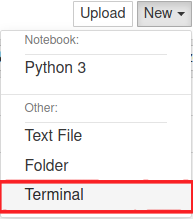

Par contre, il n'est malheureusement pas possible d'obtenir un terminal si Google Colab est utilisé.

## Utilisation de Google Colab

Si vous utilisez Google Colab, suivez les instructions ci-dessous.

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. Installer ensuite deeplib avec la comamnde suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git
!pip install --upgrade poutyne

# Laboratoire 1: Introduction à PyTorch

Le but de ce laboratoire est de se familiariser avec PyTorch en l'utilisant pour faire de la classification sur deux jeux de données connus: MNIST et CIFAR-10. On aura donc une vue d'ensemble de l'utilisation de PyTorch. Prenez donc le temps de lire le code et d'essayer de comprendre en haut niveau ce qui se passe.

La cellule ci-dessous importe les différents modules qui sont utilisés dans ce notebook. Notamment, en plus de différents modules de PyTorch (torch.\*), on importe deeplib qui est une libraire écrite spécialement pour les notebook de ce cours.

In [19]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
%matplotlib inline

from deeplib.datasets import load_mnist, load_cifar10, train_valid_loaders
from sklearn.metrics import accuracy_score
from deeplib.net import MnistNet, CifarNet
from deeplib.history import History, plot_poutyne_history
from deeplib.visualization import plot_images

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

## MNIST

MNIST est un jeu de données contenant des images de chiffres manuscrits.

Le jeu de données est séparé comme suit: 50 000 images sont utilisées en entraînement et 10 000 en test.

Pour obtenir les objets [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) de PyTorch pour les exemples d'entraînement et de test, on utilise la fonction `load_mnist` dans deeplib qui utilise la librairie [`torchvision`](https://pytorch.org/docs/stable/torchvision/index.html) sous le capot.

In [2]:
mnist, mnist_test = load_mnist()

### Visualisation du jeu de données

Exécuter cette cellule plusieurs fois pour visualiser différents exemples du jeu de données.

La fonction `plot_images` est une fonction venant de deeplib.

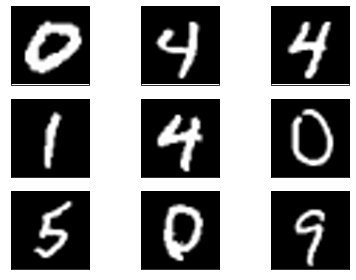

In [3]:
idx = random.sample([x for x in range(len(mnist))], 9)
images = [np.array(mnist[i][0]) for i in idx]
targets = [mnist[i][1] for i in idx]

plot_images(images, targets, gray=True)

On peut indexer les datasets de PyTorch comme une liste. Généralement, chaque élément d'un dataset va être un tuple `(x, y)`. Le terme `x` va correspondre à notre exemple. Le terme `y` va correspondre à notre étiquette (ou label, target) sous forme d'index (par exemple, on pourrait avoir 0 pour chien et 1 pour chat si on cherchait à différencier des images de chats et de chien). Avec MNIST, `x` sera les pixels de l'image et `y` sera le chiffre à classifier.

Les cellules ci-dessous affichent le premier élément du jeu de données.

In [4]:
mnist[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FC3A74B8AC0>, 5)

On affiche l'image.

In [5]:
mnist[0][0]

On affiche l'étiquette.

In [6]:
mnist[0][1]

5

Les datasets de torchvision ont un attribut permettant de d'effectuer une transformation sur nos images. Dans notre cas, on veut simplement obtenir un tenseur pour PyTorch.

In [7]:
mnist.transform = ToTensor()
mnist_test.transform = ToTensor()

## Entraînement

Pour l'entraînement, on a besoin d'une fonction ``train`` pour entraîner le réseau, d'une fonction ``validate`` pour estimer la performance de notre modèle au fur et à mesure de l'optimisation et d'une fonction ``test`` pour estimer la performance de notre modèle sur des données jamais observées.

Pour chaque epoch, la fonction ``train`` passe au travers de toutes les images du jeu de données dans un ordre aléatoire et met à jour les poids du réseau selon la perte calculée.<br>
Pour entraîner le réseau, la fonction doit recevoir 3 hyperparamètres: 
1. le nombre d'epochs qui indique combien de fois toutes les images du jeu de données seront observées; 
2. la taille de la batch qui indique combien d'images seront traitées à la fois;
3. le taux d'apprentissage qui détermine la vitesse à laquelle chaque poids du réseau sera modifié.

Pendant l'entraînement, une partie des données est utilisée pour créer un ensemble de validation qui permet d'estimer les performances de généralisation du modèle.

Finalement, on sauvegarde aussi quelques informations importantes afin de visualiser ce qui se passe pendant l'entraînement.

Le code est commenté pour donner plus de détails du déroulement de l'entraînement et des subtilités de PyTorch. Vous aurez l'occation dans les prochains laboratoires de mieux comprendre tous ces détails.

In [8]:
def train(model, dataset, n_epoch, batch_size, learning_rate, use_gpu=False):
    """
    Entraîne un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        n_epoch (int): Le nombre d'epochs.
        batch_size (int): La taille des batchs.
        learning_rate (float): Le taux d'apprentissage pour SGD.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    
    Returns:
        Retourne un objet History permettant de faire des graphiques
        de l'évolution de l'entraînement.
    """
    # La classe History vient de deeplib. Elle va nous permettre de faire les graphiques
    # donnant l'évolution de la perte et de l'exactitude (accuracy).
    history = History()
    
    # La fonction de perte que nous utilisons ici est l'entropy croisée
    # L'optimiseur que nous utilisons ici est le classique SGD.
    # Des liens vers la documentation de PyTorch sont en commentaires.
    criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)  # https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
    
    # La fonction train_valid_loaders vient de deeplib. Elle nous retourne deux DataLoaders:
    # un pour l'ensemble d'entraînement et un pour l'ensemble de test. Essentiellement,
    # DataLoader est une classe de PyTorch nous permettant de faire des batchs avec la taille
    # désirée. La fonction train_valid_loaders effectue la répartition aléatoire des exemples
    # en entraînement et en validation.
    train_loader, valid_loader = train_valid_loaders(dataset, batch_size=batch_size)

    # C'est ici que la boucle d'entraînement commence. On va donc faire n_epochs epochs.
    for i in range(n_epoch):
        # Les réseaux de neurones avec PyTorch ont un méthode train() en plus d'une méthode 
        # eval(). Ces deux méthodes indique au réseau s'il est en entraînement ou bien en test.
        # Ceci permet au réseau de modifier son comportement en fonction. On va le voir plus tard
        # certaines couches agissent différemment selon le mode, nommément le dropout et la 
        # batch normalization.
        model.train()
        
        # La prochaine ligne active simplement le calcul du gradient. Le gradient est ce qui va
        # nous permettre de mettre à jour les poids du réseau de neurones. En test, le calcul du
        # gradient sera désactivé étant qu'il n'est pas nécessaire et qu'il peut engendrer des 
        # fuites de mémoire si la rétro-propagation n'est pas effectuée.
        with torch.enable_grad():
            # À chaque epoch, on parcours l'ensemble d'entraînement au complet via le DataLoader
            # qui nous le retourne en batch (x, y) comme mentioné plus haut. La variable inputs 
            # correspond donc à une batch d'exemples (x) et targets correspond à une batch 
            # d'étiquettes (y).
            for inputs, targets in train_loader:
                # On envoie les exemples et leurs étiquettes sur GPU via la méthode cuda() si 
                # demandé.
                if use_gpu:
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                # La méthode zero_grad() de l'optimiseur permet de mettre la valeur du gradient
                # à zéro de façon à effacer le gradient calculé auparavant. Si ceci n'était pas 
                # fait, le nouveau gradient serait additionné à l'ancien gradient ce qui poserait
                # problème.
                optimizer.zero_grad()
                
                # C'est ici que finalement le réseau de neurones est appelé. On lui donne en entrée
                # un exemple et en sortie il nous donne ses prédictions (ici, des scores de 
                # classification).
                output = model(inputs)

                # Une fois nos prédictions obtenues, on calcule la perte avec la fonction de perte 
                # qui nous retourne un tenseur scalaire. 
                loss = criterion(output, targets)
                # Ce tenseur scalaire nous permet de calculer le gradient. C'est ce que la méthode
                # backward() vient faire pour nous via la rétropropagation.
                loss.backward()
                # Une fois que le gradient est calculé, il ne reste que mettre à jour les poids du
                # réseau de neurones. C'est ce que la méthode step() de l'optimiseur vient faire
                # pour nous.
                optimizer.step()

        # Après chaque epoch d'entraînement, on va venir calculer la perte et l'exactitude 
        # (accuracy) sur l'ensemble d'entraînement et de validation.
        train_acc, train_loss = validate(model, train_loader, use_gpu)
        val_acc, val_loss = validate(model, valid_loader, use_gpu)
        history.save(train_acc, val_acc, train_loss, val_loss, learning_rate)
        print('Epoch {} - Train acc: {:.2f} - Val acc: {:.2f} - Train loss: {:.4f} - Val loss: {:.4f}'.format(i, train_acc, val_acc, train_loss, val_loss))

    return history

Pour chaque image du jeu de donnée, la fonction ``validate`` fait prédire une classe au réseau entraîné et compare le résultat avec la vraie réponse. Elle retourne le pourcentage de réponse correcte ainsi que la perte moyenne.

In [9]:
def validate(model, valid_loader, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        valid_loader (DataLoader): Un DataLoader PyTorch tel qu'instancié dans train() 
            et test().
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
            
    Returns:
        Retourne un tuple (exactitude, perte) pour les données du DataLoader en argument.
    """
    
    # Les étapes de la fonction validate est très similaire à celle de la fonction train.
    # Essentiellement, le réseau est mis en mode évaluation au lieu d'entraînement et le 
    # calcul du gradient est désactivé. Il n'y a bien sûr pas d'utilisation d'un optimiseur.
    true = []
    pred = []
    val_loss = []
    
    criterion = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        for inputs, targets in valid_loader:
            if use_gpu:
                inputs = inputs.cuda()
                targets = targets.cuda()

            output = model(inputs)

            predictions = output.max(dim=1)[1]

            val_loss.append(criterion(output, targets).item())
            true += targets.cpu().numpy().tolist()
            pred += predictions.cpu().numpy().tolist()

    return accuracy_score(true, pred) * 100, sum(val_loss) / len(val_loss)

La fonction `test` est utilisée à la fin de l'entraînement sur l'ensemble de test et affiche le pourcentage de réponse correcte ainsi que la perte moyenne sur cet ensemble.

In [10]:
def test(model, dataset, batch_size, use_gpu=False):
    """
    Test un réseau de neurones de classification pour un certain nombre d'epochs 
    avec PyTorch. La fonction affiche l'exactitude et la perte moyenne.
    
    Args:
        model (nn.Module): Un réseau de neurones instancié avec PyTorch.
        dataset (Dataset): Un jeu de données PyTorch.
        batch_size (int): La taille des batchs.
        use_gpu (bool): Si les données doivent être envoyées sur GPU.
    """
    test_loader = DataLoader(dataset, batch_size=batch_size)
    test_acc, test_loss = validate(model, test_loader, use_gpu=use_gpu)
    print('Test acc: {:.2f} - Test loss: {:.4f}'.format(test_acc, test_loss))

Entraînons un modèle.

In [11]:
model = MnistNet()
model.cuda()

n_epoch = 10
batch_size = 64
learning_rate = 0.1

history = train(model, mnist, n_epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 95.76 - Val acc: 95.58 - Train loss: 0.1288 - Val loss: 0.1357
Epoch 1 - Train acc: 98.39 - Val acc: 97.92 - Train loss: 0.0528 - Val loss: 0.0617
Epoch 2 - Train acc: 98.49 - Val acc: 97.88 - Train loss: 0.0496 - Val loss: 0.0624
Epoch 3 - Train acc: 98.64 - Val acc: 98.11 - Train loss: 0.0420 - Val loss: 0.0582
Epoch 4 - Train acc: 99.08 - Val acc: 98.43 - Train loss: 0.0291 - Val loss: 0.0468
Epoch 5 - Train acc: 99.42 - Val acc: 98.65 - Train loss: 0.0194 - Val loss: 0.0428
Epoch 6 - Train acc: 99.53 - Val acc: 98.84 - Train loss: 0.0153 - Val loss: 0.0398
Epoch 7 - Train acc: 99.53 - Val acc: 98.83 - Train loss: 0.0146 - Val loss: 0.0390
Epoch 8 - Train acc: 99.56 - Val acc: 98.65 - Train loss: 0.0148 - Val loss: 0.0448
Epoch 9 - Train acc: 99.84 - Val acc: 99.03 - Train loss: 0.0067 - Val loss: 0.0325


En utilisant la méthode `display` de la classe `History`, on peut visualiser l'entraînement précédent.

Le premier graphique montre l'évolution de l'exactitude du modèle sur le jeu de données d'entraînement et sur celui de validation. Le deuxième montre la perte sur les deux jeux de données.

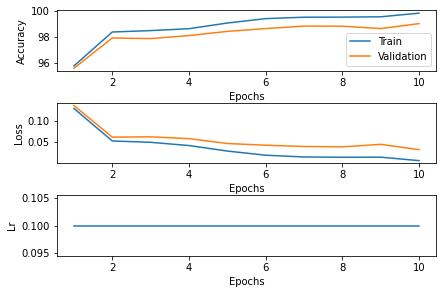

In [12]:
history.display()

Finalement, évaluons les performances du modèle sur le jeu de données de test.

In [13]:
test(model, mnist_test, batch_size, use_gpu=True)

Test acc: 99.06 - Test loss: 0.0301


## Différences CPU - GPU

Pour faire exécuter le code sur GPU, il faut déplacer le model, les inputs et les targets sur le GPU. 

Le réseau contient deux couches de convolutions qui servent à extraire des caractéristiques des images tandis que les couches linéaires servent de classifieur. Il s'agit d'un pipeline commun pour toutes les classes.

In [14]:
model_gpu = MnistNet()
model_gpu.cuda()

MnistNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2450, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Comparons le temps d'exécution sur CPU et sur GPU. Pour ce faire, entraînons le réseau pour 5 epochs sur CPU et 5 epochs sur GPU et comparons les temps de traitement.

In [15]:
epoch = 5
batch_size = 256
lr = 0.1

Pendant l'entraînement, vérifier l'utilisation du CPU avec la commande ``top`` (ou ``htop``). Voir la section "Utilisation de commandes" tout en haut du notebook pour l'utilisation de commande.

In [16]:
print('Training on CPU')
model = MnistNet()

start_cpu = time.time()
history = train(model, mnist, epoch, batch_size, lr)
end_cpu = time.time()

cpu_time = end_cpu - start_cpu

Training on CPU
Epoch 0 - Train acc: 87.94 - Val acc: 88.09 - Train loss: 0.4051 - Val loss: 0.4089
Epoch 1 - Train acc: 94.88 - Val acc: 94.33 - Train loss: 0.1663 - Val loss: 0.1765
Epoch 2 - Train acc: 96.84 - Val acc: 96.47 - Train loss: 0.1054 - Val loss: 0.1120
Epoch 3 - Train acc: 97.08 - Val acc: 96.82 - Train loss: 0.0928 - Val loss: 0.1028
Epoch 4 - Train acc: 97.95 - Val acc: 97.62 - Train loss: 0.0680 - Val loss: 0.0778


Pour vous assurer que le réseau entraîne bien sur GPU, utiliser la commande 

``watch -n 1 nvidia-smi`` 

Observer l'utilisation de la carte et la quantité de mémoire utilisée pendant l'entraînement.

In [17]:
print('Training on GPU')
model_gpu = MnistNet()
model_gpu.cuda()

start_gpu = time.time()
history_gpu = train(model_gpu, mnist, epoch, batch_size, lr, use_gpu=True)
end_gpu = time.time()

gpu_time = end_gpu - start_gpu

Training on GPU
Epoch 0 - Train acc: 85.01 - Val acc: 84.96 - Train loss: 0.4375 - Val loss: 0.4369
Epoch 1 - Train acc: 94.30 - Val acc: 94.27 - Train loss: 0.1780 - Val loss: 0.1789
Epoch 2 - Train acc: 95.86 - Val acc: 95.60 - Train loss: 0.1278 - Val loss: 0.1334
Epoch 3 - Train acc: 97.18 - Val acc: 97.05 - Train loss: 0.0930 - Val loss: 0.0963
Epoch 4 - Train acc: 94.95 - Val acc: 95.12 - Train loss: 0.1639 - Val loss: 0.1640


In [18]:
print('CPU - Training time: {:.2f}s'.format(cpu_time))
print('GPU - Training time: {:.2f}s'.format(gpu_time))
print('Ratio: {:.2f}x'.format((cpu_time) / (gpu_time)))

CPU - Training time: 106.92s
GPU - Training time: 38.45s
Ratio: 2.78x


## CIFAR 10

CIFAR-10 est un jeu de données comportant des images séparés en 10 classes:<br>
0 - Avion<br>
1 - Voiture<br>
2 - Oiseau<br>
3 - Chat<br>
4 - Chevreuil<br>
5 - Chien<br>
6 - Grenouille<br>
7 - Cheval<br>
8 - Bateau<br>
9 - Camion<br>

Le jeu de données contient 50000 images d'entraînement. On en utilisera 40000 pour l'entraînement et 10000 pour la validation.

### Visualisation du jeu de données

In [2]:
cifar, cifar_test = load_cifar10()

Files already downloaded and verified
Files already downloaded and verified


Encore une fois, vous pouvez exécuter cette cellule plusieurs fois pour bien visualiser le jeu de données.

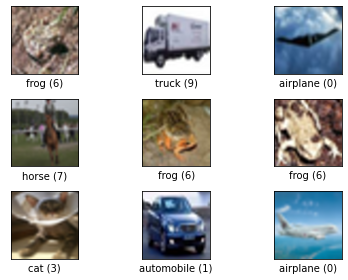

In [3]:
label_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

idx = random.sample([x for x in range(len(cifar))], 9)
images = [np.array(cifar[i][0]) for i in idx]
images = np.asarray(images)
targets = [cifar[i][1] for i in idx]

plot_images(images, targets, label_names)

Encore une fois, on désire obtenir des tensors de notre dataset.

In [3]:
cifar.transform = ToTensor()
cifar_test.transform = ToTensor()

### Exercices

Utilisez les 3 cellules suivantes pour répondre aux questions.

In [22]:
epoch = 5
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)

Epoch 0 - Train acc: 49.40 - Val acc: 48.70 - Train loss: 1.4704 - Val loss: 1.4921
Epoch 1 - Train acc: 55.69 - Val acc: 53.45 - Train loss: 1.2404 - Val loss: 1.3043
Epoch 2 - Train acc: 63.70 - Val acc: 59.84 - Train loss: 1.0536 - Val loss: 1.1458
Epoch 3 - Train acc: 68.10 - Val acc: 62.97 - Train loss: 0.9129 - Val loss: 1.0642
Epoch 4 - Train acc: 73.24 - Val acc: 65.70 - Train loss: 0.7770 - Val loss: 0.9793


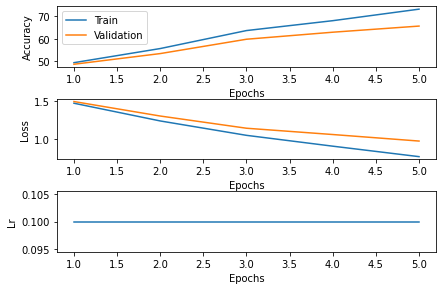

In [23]:
history.display()

In [24]:
test(model, cifar_test, batch_size, use_gpu=True)

Test acc: 65.60 - Test loss: 0.9779


### Effet du nombre d'epochs

Modifiez le nombre d'epochs et observez les performances du réseau.

S'il est trop petit?

**Ceci est équivalent à arrêter l'entraînement de manière prématuré. Donc, si on arrête l'entraînement après seulement 2 epochs par exemple, on voit clairement que notre modèle n'a pas été entraîné à son plein potentiel. On parle ici de sous-apprentissage.**

Que se passe-t-il s'il est trop grand?

**Ceci un exemple de surapprentissage. En surapprentissage, le réseau de neurones est capable de mémoriser les exemples d'entraînement. On peut le voir dans les courbes d'apprentissage ci-dessous. Dans la courbe de la fonction de perte, on peut voir que la perte en entraînement est très basse alors qu'en validation, elle descend au début de l'entraînement et monte sans cesse par la suite. Similairement, de manière plus subtile, l'accuracy en validation monte en premier et décroit par tranquillement par la suite.**

Epoch 0 - Train acc: 46.30 - Val acc: 45.26 - Train loss: 1.5178 - Val loss: 1.5524
Epoch 1 - Train acc: 55.73 - Val acc: 53.39 - Train loss: 1.2458 - Val loss: 1.3127
Epoch 2 - Train acc: 63.22 - Val acc: 59.08 - Train loss: 1.0646 - Val loss: 1.1657
Epoch 3 - Train acc: 68.01 - Val acc: 63.18 - Train loss: 0.9132 - Val loss: 1.0616
Epoch 4 - Train acc: 70.24 - Val acc: 63.20 - Train loss: 0.8680 - Val loss: 1.0643
Epoch 5 - Train acc: 77.52 - Val acc: 67.26 - Train loss: 0.6721 - Val loss: 0.9416
Epoch 6 - Train acc: 78.64 - Val acc: 67.32 - Train loss: 0.6238 - Val loss: 0.9768
Epoch 7 - Train acc: 83.86 - Val acc: 68.22 - Train loss: 0.4960 - Val loss: 0.9431
Epoch 8 - Train acc: 84.15 - Val acc: 67.18 - Train loss: 0.4758 - Val loss: 0.9981
Epoch 9 - Train acc: 85.06 - Val acc: 66.76 - Train loss: 0.4330 - Val loss: 1.0866
Epoch 10 - Train acc: 88.75 - Val acc: 67.44 - Train loss: 0.3315 - Val loss: 1.1028
Epoch 11 - Train acc: 91.79 - Val acc: 67.94 - Train loss: 0.2571 - Val los

Epoch 97 - Train acc: 95.44 - Val acc: 61.96 - Train loss: 0.2537 - Val loss: 7.1525
Epoch 98 - Train acc: 93.35 - Val acc: 61.44 - Train loss: 0.3970 - Val loss: 7.0248
Epoch 99 - Train acc: 93.48 - Val acc: 60.62 - Train loss: 0.3747 - Val loss: 6.7560


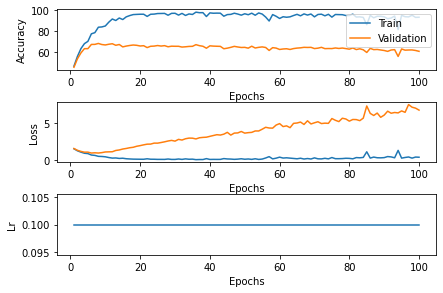

Test acc: 60.79 - Test loss: 6.6618


In [25]:
epoch = 100
batch_size = 64
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet de la taille de la batch

Modifiez la taille de la batch et observez l'utilisation de la carte graphique. 


Sur quoi est-ce que la taille de la batch semble avoir le plus d'impact?

> Pour pouvoir observer les changements au niveau de l'utilisation de la mémoire, il est préférable de redémarrer le kernel du notebook entre chaque tentative (dans le menu Kernel). Si vous prenez ce chemin, n'oubliez pas d'exécuter les cellules nécessaires plus haut dans le notebook (les imports, les fonctions train, validate, etc.).

**Évidemment, niveau mémoire, la taille de la batch a une grande importance. Pour une batch très petite, peu de mémoire sera utilisé et pour une batch très grande, une grande quantité sera nécessaire. Au niveau de l'utilisation des coeurs du GPUs, plus la taille de la batch est grand, plus grande l'utilisation des coeurs sera. Une plus grande batch peut donc mener à une utilisation plus efficace des ressources de calcul qui sont limités. Par contre, il faut aussi prendre en compte que la taille de la batch a un impact sur les performances.**

Est-ce qu'elle impacte les performances?

**En effet, on note que si l'on va dans les extrêmes, les performances sont dégradées d'une manière ou d'une autre. Dépendamment du réseau et de son initialisation, ceci peut prendre la forme d'un apprentissage qui ne s'effectue simplement pas, un apprentissage plus lent ou bien à un grand surapprentissage. Ceci est du au fait que les réseaux de neurones ne sont pas des modèles dits convexes et donc ont besoin d'un certain niveau de stochaïsticité (c'est-à-dire de l'aléatoire) pour être capable de les entraîner. La taille de la batch est donc un hyperparamètre important pour avoir un apprentissage effectif.**

Que peut-on conclure sur la taille de batch optimale?

> Note: on ne demande pas de trouver cette taille optimale mais de commenter sur la manière dont on la trouverait.

**La taille de batch optimale sera donc un trade-off entre l'utilisation optimale des ressources du GPUs et sur les perfomances obtenues. On peut donc tenter d'augmenter la taille de la batch tout en obtenant des perfomances optimales.**

Epoch 0 - Train acc: 10.14 - Val acc: 9.43 - Train loss: 2.3260 - Val loss: 2.3285
Epoch 1 - Train acc: 9.99 - Val acc: 10.04 - Train loss: 2.3184 - Val loss: 2.3206
Epoch 2 - Train acc: 9.98 - Val acc: 10.10 - Train loss: 2.3342 - Val loss: 2.3306
Epoch 3 - Train acc: 9.92 - Val acc: 10.33 - Train loss: 2.3303 - Val loss: 2.3303
Epoch 4 - Train acc: 10.14 - Val acc: 9.43 - Train loss: 2.3115 - Val loss: 2.3120


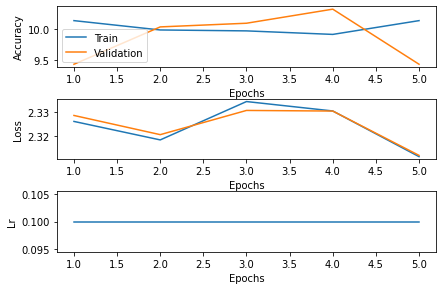

Test acc: 10.00 - Test loss: 2.3116


In [26]:
epoch = 5
batch_size = 1
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 10.87 - Val acc: 10.75 - Train loss: 2.3864 - Val loss: 2.3786
Epoch 1 - Train acc: 11.79 - Val acc: 11.57 - Train loss: 2.5608 - Val loss: 2.5630
Epoch 2 - Train acc: 23.35 - Val acc: 23.73 - Train loss: 2.1197 - Val loss: 2.1169
Epoch 3 - Train acc: 24.35 - Val acc: 24.03 - Train loss: 2.0461 - Val loss: 2.0467
Epoch 4 - Train acc: 33.05 - Val acc: 32.71 - Train loss: 1.9327 - Val loss: 1.9376


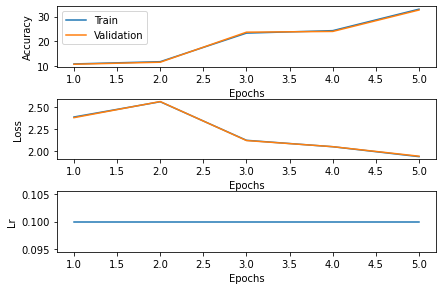

Test acc: 33.48 - Test loss: 1.9285


In [27]:
epoch = 5
batch_size = 1024
learning_rate = 0.1

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Effet du taux d'apprentissage (lr)

Finalement, observez l'impact du taux d'apprentissage sur l'entraînement.

Que se passe-t-il s'il est trop grand?

**D'une manière similaire aux impacts de la taille de la batch, si le taux d'apprentissage au trop grand, les performances sont dégradées d'une manière ou d'une autre. Dépendamment du réseau et de son initialisation, ceci peut prendre la forme d'un apprentissage qui ne s'effectue simplement pas ou d'un apprentissage très instable. Le taux d'apprentissage est donc aussi un hyperparamètre important pour avoir un apprentissage effectif.**

S'il est trop petit?

**Si le taux d'apprentissage est trop petit, l'apprentissage se fera d'une manière très lente et parfois il ne se fera pas étant donné la stochaïsticité de l'entraînement.**

Epoch 0 - Train acc: 15.32 - Val acc: 14.99 - Train loss: 2.2826 - Val loss: 2.2835
Epoch 1 - Train acc: 20.45 - Val acc: 20.87 - Train loss: 2.2544 - Val loss: 2.2558
Epoch 2 - Train acc: 20.45 - Val acc: 20.83 - Train loss: 2.2047 - Val loss: 2.2055
Epoch 3 - Train acc: 24.68 - Val acc: 24.95 - Train loss: 2.1351 - Val loss: 2.1360
Epoch 4 - Train acc: 27.33 - Val acc: 28.03 - Train loss: 2.0732 - Val loss: 2.0727


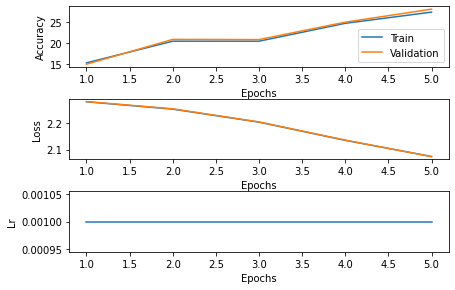

Test acc: 27.92 - Test loss: 2.0697


In [28]:
epoch = 5
batch_size = 64
learning_rate = 0.001

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

Epoch 0 - Train acc: 10.14 - Val acc: 9.43 - Train loss: 2.3636 - Val loss: 2.3652
Epoch 1 - Train acc: 9.92 - Val acc: 10.33 - Train loss: 2.3488 - Val loss: 2.3416
Epoch 2 - Train acc: 9.98 - Val acc: 10.10 - Train loss: 2.3567 - Val loss: 2.3636
Epoch 3 - Train acc: 9.97 - Val acc: 10.11 - Train loss: 2.3332 - Val loss: 2.3328
Epoch 4 - Train acc: 9.99 - Val acc: 10.04 - Train loss: 2.4122 - Val loss: 2.4110


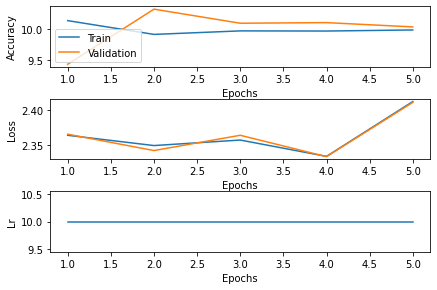

Test acc: 10.00 - Test loss: 2.4118


In [29]:
epoch = 5
batch_size = 64
learning_rate = 10.

model = CifarNet()
model.cuda()

history = train(model, cifar, epoch, batch_size, learning_rate, use_gpu=True)
history.display()
test(model, cifar_test, batch_size, use_gpu=True)

### Défi

Modifiez les hyperparamètres pour améliorer les performances du réseau.<br>
Essayez d'obtenir plus de 65% en test.

Vous pouvez aussi tenter de battre le state of the art: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130

## Utilisation d'une librairie pour l'entraînement

Comme vous l'avez peut-être remarqué, les fonctions `train` et `test` que nous avons utilisé sont bien pratiques. Il existe différentes librairies nous permettant de ne pas devoir définir ces fonctions pour chacun de nos projets. Lorsqu'approprié, nous utiliserons une de ces librairies dans les laboratoires de ce cours. Nous avons choisi d'utiliser la librairie [Poutyne](https://poutyne.org/) qui est développé ici même à l'Université Laval.

Définissons nos hyperparamètres usuels.

In [6]:
epoch = 5
batch_size = 64
learning_rate = 0.1

Poutyne peut prendre en entrée des Numpy arrays ou des tenseurs via sa méthode `fit` ou bien des objets qui sont itérables comme des `DataLoader` de PyTorch via sa méthode `fit_generator`. Définissons donc des `DataLoader` comme le font les fonctions `train` et `test`.

In [7]:
train_loader, valid_loader = train_valid_loaders(cifar, batch_size=batch_size)
test_loader = DataLoader(cifar_test, batch_size=batch_size)

Importons Poutyne.

In [8]:
import poutyne as pt

Procédons maintenant à l'entraînement. La principales classes de Poutyne est la classe [`Model`](https://poutyne.org/model.html) qui nous servira à effectuer l'entraînement. Également, n'hésitez pas à jeter un coup d'oeil à la classe [`Experiment`](https://poutyne.org/experiment.html) qui permet de sauvegarder automatiquement un tas d'information comme des points de sauvegarde (checkpoints) et des logs.

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|6.14s loss: 1.952941 acc: 29.167500 val_loss: 1.624843 val_acc: 41.710000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|6.30s loss: 1.400795 acc: 50.405000 val_loss: 1.389985 val_acc: 50.390000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|6.24s loss: 1.167145 acc: 59.207500 val_loss: 1.145510 val_acc: 59.520000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|6.20s loss: 1.013245 acc: 64.732500 val_loss: 1.062788 val_acc: 63.730000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|6.14s loss: 0.893718 acc: 69.087500 val_loss: 1.041496 val_acc: 64.050000


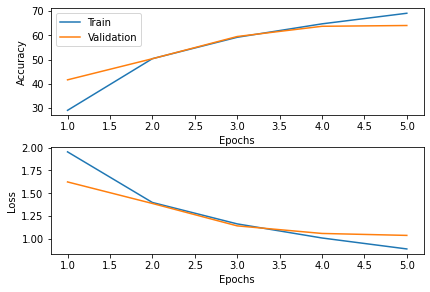

test_loss: 1.0288 test_acc: 64.31


In [32]:
# On instance notre réseau ainsi que l'optimiseur comme à l'habitude.
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

# On crée un objet Model de Poutyne avec la fonction de perte et les métriques souhaitées.
model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

# Comme dit précedemment, on utilise la méthode `fit_generator` pour procéder à l'entraînement.
history = model.fit_generator(train_loader, valid_loader, epochs=epoch)

# On utilise la fonction plot_poutyne_history venant de deeplib.
plot_poutyne_history(history)

# Finalement, on utilise la fonction evaluate_generator pour calculer la perte et l'exactitude sur
# notre ensemble de test.
test_loss, test_acc = model.evaluate_generator(test_loader)
print('test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Un aspect intéressant de Poutyne est l'utilisation de [callbacks](https://poutyne.org/callbacks.html) qui permettent d'effectuer des actions pendant l'entraînement. Dans l'exemple suivant, on utilise deux types de callbacks: un permettant de faire des points de sauvegarde et l'autre permettant de logger dans un CSV les statistiques d'entraînement.

In [31]:
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=learning_rate)

os.makedirs('logs', exist_ok=True)

callbacks = [
    # Effectue des points de sauvegarde après chaque epoch dans le fichier last_epoch.ckpt.
    pt.ModelCheckpoint('logs/last_epoch.ckpt', temporary_filename='last_epoch.ckpt.tmp'),

    # Effectue des points de sauvegarde à chaque fois qu'il y a amélioration de l'exactitude
    # en validation. Le nom du fichier va contenir le numéro de l'epoch correspondante.
    pt.ModelCheckpoint('logs/best_epoch_{epoch}.ckpt', monitor='val_acc', mode='max', save_best_only=True, restore_best=True, verbose=True, temporary_filename='best_epoch.ckpt.tmp'),

    # Sauvegarde toutes les stats affichés dans un fichier CSV.
    pt.CSVLogger('logs/log.csv'),
]

model = pt.Model(net, optimizer, 'cross_entropy', batch_metrics=['accuracy'])
model.cuda()

history = model.fit_generator(train_loader, valid_loader, epochs=epoch, callbacks=callbacks)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|6.33s loss: 1.873413 acc: 32.692500 val_loss: 1.495894 val_acc: 46.930000
Epoch 1: val_acc improved from -inf to 46.93000, saving file to logs/best_epoch_1.ckpt
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|6.30s loss: 1.378607 acc: 50.810000 val_loss: 1.426233 val_acc: 48.480000
Epoch 2: val_acc improved from 46.93000 to 48.48000, saving file to logs/best_epoch_2.ckpt
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|6.30s loss: 1.163675 acc: 59.187500 val_loss: 1.136612 val_acc: 59.820000
Epoch 3: val_acc improved from 48.48000 to 59.82000, saving file to logs/best_epoch_3.ckpt
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|6.18s loss: 1.013531 acc: 64.500000 val_loss: 1.035435 val_acc: 63.870000
Epoch 4: val_acc improved from 59.82000 to 63.87000, saving file to logs/best_epoch_4.ckpt
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|6.12s loss: 0.893572 acc: 69.015000 val_loss

Une fois l'entraînement effectué, on peut aller lire le fichier de log CSV avec la librairie pandas.

In [29]:
pd.read_csv('logs/log.csv')

,epoch,time,lr,loss,acc,val_loss,val_acc
0,1,6.296042,0.1,1.835248,33.9025,1.484807,47.10
1,2,6.200331,0.1,1.392982,50.4575,1.331290,52.85
2,3,6.309575,0.1,1.192213,58.2250,1.207756,57.70
3,4,6.269445,0.1,1.037379,63.6675,1.060728,62.69
4,5,6.322692,0.1,0.913463,68.3450,0.978704,65.95


Étant donné le court entraînement, on devrait avoir obtenu des points de sauvegarde pour chacun des epochs. Amusez vous à charger différents epochs et à regarder l'impact sur l'ensemble de test.

In [30]:
model.load_weights('logs/best_epoch_4.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 4: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

model.load_weights('logs/best_epoch_5.ckpt')
test_loss, test_acc = model.evaluate_generator(test_loader)
print('Epoch 5: test_loss: {:.4f} test_acc: {:.2f}'.format(test_loss, test_acc))

Epoch 4: test_loss: 1.0483 test_acc: 63.07
Epoch 5: test_loss: 0.9681 test_acc: 66.29
